In [ ]:
!pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gym
import numpy as np

In [ ]:
# check and use GPU if available if not use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym

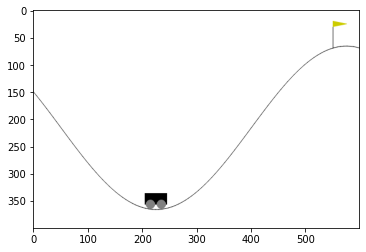

In [ ]:
env = gym.make('MountainCarContinuous-v0') #('LunarLanderContinuous-v2')
env.reset()

prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(200):
    env.render(mode='rgb_array')
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    if done:
        env.reset()
        
env.close()

In [ ]:

#Experience Replay Buffer
# replay buffer from and some code based on https://github.com/sfujim/TD3

# create replay buffer of tuples of (state, next_state, action, reward, done)
class ReplayBuffer():
    def __init__(self, max_size=1e6):
        self.storage = []
        self.max_size = max_size
        self.ptr = 0

    def add(self, data):
        if len(self.storage) == self.max_size:
            self.storage[int(self.ptr)] = data
            self.ptr = (self.ptr + 1) % self.max_size
        else:
            self.storage.append(data)

    def sample(self, batch_size):
        ind = np.random.randint(0, len(self.storage), size=batch_size)
        x, y, u, r, d = [], [], [], [], []

        for i in ind: 
            X, Y, U, R, D = self.storage[i]
            x.append(np.array(X, copy=False))
            y.append(np.array(Y, copy=False))
            u.append(np.array(U, copy=False))
            r.append(np.array(R, copy=False))
            d.append(np.array(D, copy=False))

        return np.array(x), np.array(y), np.array(u), np.array(r).reshape(-1,1), np.array(d).reshape(-1,1)

In [ ]:
class ActorNet(nn.Module):
    def __init__(self, state_size, action_size, hidden_size, action_max):
        super(ActorNet, self).__init__()
        self.dense_layer_1 = nn.Linear(state_size, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, action_size)
        self.action_max = action_max
    
    def forward(self, x):
        x = torch.clamp(x,-1.1,1.1)
        x = F.relu(self.dense_layer_1(x))
        x = F.relu(self.dense_layer_2(x))
        return torch.tanh(self.output(x)) * self.action_max
    
class CriticNet(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super(CriticNet, self).__init__()
        self.dense_layer_1 = nn.Linear(state_size+action_size, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, 1)
    
    def forward(self, x, a):
        x = torch.clamp(x,-1.1,1.1)
        x = F.relu(self.dense_layer_1(torch.cat((x,a),dim=1)))
        x = F.relu(self.dense_layer_2(x))
        return self.output(x)

In [ ]:
class DDPGAgent():
    def __init__(self, state_size, action_size, hidden_size, actor_lr, critic_lr, discount,
                 min_action, max_action, exploration_noise):
        self.action_size = action_size
        self.actor = ActorNet(state_size, action_size, hidden_size, max_action).to(device)
        self.actor_target = ActorNet(state_size, action_size, hidden_size, max_action).to(device)
        self.critic = CriticNet(state_size, action_size, hidden_size).to(device)
        self.critic_target = CriticNet(state_size, action_size, hidden_size).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.critic_target.load_state_dict(self.critic.state_dict())
        
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.discount = discount
        self.min_action = min_action
        self.max_action = max_action
        self.exploration_noise = exploration_noise
        
    def select_action(self, state):
        #get action probs then randomly sample from the probabilities
        with torch.no_grad():
            input_state = torch.FloatTensor(state).to(device)
            action = self.actor(input_state)
            #detach and turn to numpy to use with np.random.choice()
            action = action.detach().cpu().numpy()
            #in DDPG add noise for exploration
            action = (action + np.random.normal(0., self.exploration_noise, 
                       size=self.action_size)).clip(self.min_action, self.max_action)   
        return action

    
    def train(self, replay_buffer, batch_size):
        # sample a batch from the replay buffer
        x0, x1, a, r, d = replay_buffer.sample(batch_size)
        # turn batches into tensors and use GPU if available
        state_batch = torch.FloatTensor(x0).to(device)
        next_state_batch = torch.FloatTensor(x1).to(device)
        action_batch = torch.FloatTensor(a).to(device)
        reward_batch = torch.FloatTensor(r).to(device)
        flipped_done_batch = torch.FloatTensor(d).to(device) #already flipped done when adding to replay buffer

        # get target net target values
        with torch.no_grad():
            target_action = self.actor_target(next_state_batch).view(batch_size,-1)
            target_v = reward_batch + flipped_done_batch*self.discount*self.critic_target(next_state_batch, 
                                                                           target_action).view(batch_size,-1)
        # get train net values for updating the critic network    
        critic_v = self.critic(state_batch, action_batch).view(batch_size,-1)
        
        # train critic
        critic_loss = F.smooth_l1_loss(critic_v, target_v)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step() 
        
        # train actor
        train_action = self.actor(state_batch)
        actor_loss = -torch.mean(self.critic(state_batch,train_action))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step() 
        
        return actor_loss.detach().cpu().numpy(), critic_loss.detach().cpu().numpy()
        
        
    def update_target_network_soft(self, num_iter, update_every, update_tau=0.001):
        # soft target network update: update target networks with mixture of train and target
        if num_iter % update_every == 0:
            for target_var, var in zip(self.critic_target.parameters(), self.critic.parameters()):
                target_var.data.copy_((1.-update_tau) * target_var.data + (update_tau) * var.data)
            for target_var, var in zip(self.actor_target.parameters(), self.actor.parameters()):
                target_var.data.copy_((1.-update_tau) * target_var.data + (update_tau) * var.data)


# Hyperparameter

In [ ]:
# set seed
seed = 30
env.reset(seed=seed)# new 
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
# create replay buffer
replay_size = 50000 # size of replay buffer
replay_buffer = ReplayBuffer(max_size=replay_size)    

# target update hyperparameters
start_training_after = 10001 # start training NN after this many timesteps
update_target_every = 5 # update target network every this steps
tau = 0.001

episodes = 1000    
discount = 0.99
batch_size = 32
exploration_noise = 0.1 #NOISE
hidden_size = 64
actor_lr = 0.0005
critic_lr = 0.0005
reward_scale = 0.01

In [ ]:
env = gym.make('MountainCarContinuous-v0') #('LunarLanderContinuous-v2')
action_size = env.action_space.shape[0]
state_size = env.observation_space.shape[0]
min_action = env.action_space.low[0]
max_action = env.action_space.high[0]

In [ ]:
agent = DDPGAgent(state_size=state_size, action_size=action_size, hidden_size=hidden_size, 
                  actor_lr=actor_lr, critic_lr=critic_lr, discount=discount, min_action=min_action,
                  max_action=max_action, exploration_noise=exploration_noise)

In [ ]:
stats_rewards_list = [] # store stats for plotting in this
stats_every = 10 # print stats every this many episodes
total_reward = 0
timesteps = 0
episode_length = 0
stats_actor_loss, stats_critic_loss = [], []

for ep in range(episodes):
    state = env.reset()

    # stopping condition for training if agent reaches the amount of reward
    if len(stats_rewards_list) > stats_every and np.mean(stats_rewards_list[-stats_every:],axis=0)[1] > 190:
        print("Stopping at episode {} with average rewards of {} in last {} episodes".
            format(ep, np.mean(stats_rewards_list[-stats_every:],axis=0)[1], stats_every))
        break  

    # train in each episode until episode is done
    while True:
        timesteps += 1
        #env.render()
        # select an action from the agent's policy
        action = agent.select_action(state)
        
        # enter action into the env
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        episode_length += 1
        # end episode early
        if total_reward < -250:
            done = 1
        
        # add experience to replay buffer
        replay_buffer.add((state, next_state, action, reward*reward_scale, 1-float(done)))
        
        # train the agent
        if timesteps >= start_training_after:
            actor_loss, critic_loss = agent.train(replay_buffer, batch_size)
            stats_actor_loss.append(actor_loss) 
            stats_critic_loss.append(critic_loss) 
            agent.update_target_network_soft(timesteps, update_target_every)
            
        if done:
            stats_rewards_list.append((ep, total_reward, episode_length))
            total_reward = 0
            episode_length = 0  
            if timesteps >= start_training_after and ep % stats_every == 0:
                print('Episode: {}'.format(ep),
                    'Timestep: {}'.format(timesteps),
                    'Total reward: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[1]),
                    'Episode length: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[2]),
                    'Actor Loss: {:.4f}'.format(np.mean(stats_actor_loss)), 
                    'Critic Loss: {:.4f}'.format(np.mean(stats_critic_loss)))
                stats_actor_loss, stats_critic_loss = [], []
            break
        
        state = next_state

Episode: 10 Timestep: 10989 Total reward: -1.1 Episode length: 999.0 Actor Loss: 0.0523 Critic Loss: 0.0000
Episode: 20 Timestep: 20979 Total reward: -2.9 Episode length: 999.0 Actor Loss: 0.0534 Critic Loss: 0.0000
Episode: 30 Timestep: 30969 Total reward: -58.8 Episode length: 999.0 Actor Loss: 0.0462 Critic Loss: 0.0000
Episode: 40 Timestep: 40959 Total reward: -46.7 Episode length: 999.0 Actor Loss: 0.0386 Critic Loss: 0.0000
Episode: 50 Timestep: 50949 Total reward: -14.2 Episode length: 999.0 Actor Loss: 0.0341 Critic Loss: 0.0000
Episode: 60 Timestep: 60939 Total reward: -16.3 Episode length: 999.0 Actor Loss: 0.0301 Critic Loss: 0.0000
Episode: 70 Timestep: 70929 Total reward: -23.3 Episode length: 999.0 Actor Loss: 0.0285 Critic Loss: 0.0000
Episode: 80 Timestep: 80919 Total reward: -21.6 Episode length: 999.0 Actor Loss: 0.0284 Critic Loss: 0.0000
Episode: 90 Timestep: 90909 Total reward: -18.3 Episode length: 999.0 Actor Loss: 0.0287 Critic Loss: 0.0000
Episode: 100 Timestep

Text(0, 0.5, 'Episode Reward')

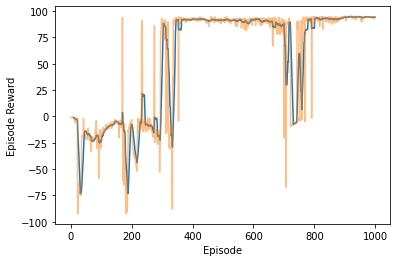

In [ ]:
# plot stats
def get_running_stat(stat, stat_len):
    cum_sum = np.cumsum(np.insert(stat, 0, 0)) 
    return (cum_sum[stat_len:] - cum_sum[:-stat_len]) / stat_len

episode, r, l = np.array(stats_rewards_list).T
cum_r = get_running_stat(r, 10)
cum_l = get_running_stat(l, 10)

# plot rewards
plt.plot(episode[-len(cum_r):], cum_r)
plt.plot(episode, r, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Reward')